<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preprocessing-the-datasets" data-toc-modified-id="Preprocessing-the-datasets-1">Preprocessing the datasets</a></span></li></ul></div>

# Preprocessing the datasets

good read : https://www.analyticsvidhya.com/blog/2018/07/hands-on-sentiment-analysis-dataset-python/

In [57]:
from utils import open_by_tweets
import nltk
import string
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#if wordcloud not already installed, run the following command : !python -m pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#uncomment the comments below if the packages have not already been downloaded

#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('averaged_perceptron_tagger')


In [4]:
#load tweets in list where each element is a tweet
with open('data/train_pos.txt',"r") as file:
    train_pos = file.read().split('\n')
    
with open('data/train_neg.txt',"r") as file:
    train_neg = file.read().split('\n')

#let's check it worked correctly
print(train_pos[0:100])


['<user> i dunno justin read my mention or not . only justin and god knows about that , but i hope you will follow me #believe 15', "because your logic is so dumb , i won't even crop out your name or your photo . tsk . <url>", '" <user> just put casper in a box ! " looved the battle ! #crakkbitch', "<user> <user> thanks sir > > don't trip lil mama ... just keep doin ya thang !", 'visiting my brother tmr is the bestest birthday gift eveerrr ! ! !', '<user> yay ! ! #lifecompleted . tweet / facebook me to let me know please', '<user> #1dnextalbumtitle : feel for you / rollercoaster of life . song cocept : life , #yolo , becoming famous ? <3 14 #followmeplz ! <3 x15', "workin hard or hardly workin rt <user> at hardee's with my future coworker <user>", "<user> i saw . i'll be replying in a bit .", 'this is were i belong', '<user> anddd to cheer #nationals2013 ?', 'we send an invitation to shop on-line ! here you will find everything you need - without leaving home ... <url>', 'just woke up 

In [30]:
for train in train_pos:
    if (train.isEmpty()):
        print('yes')

AttributeError: 'str' object has no attribute 'isEmpty'

In [ ]:
for x in train_neg:
    print(x + "\n")

## To do 
**Implement everything in methods, we need a pipeline to process test data using the same steps as for the train data**
* Remove blank tweets: Zeineb
* Open contractions & transform @ into at or u into you, etc...: Zeineb
* Separate punctuation from words like : 'word...' becomes 'word ...'
* Separate alphabet & numbers (e.g. 398stomach)
* removing repetitive letters inside word, ie, 'loooove' (seems complicated to do : https://stackoverflow.com/questions/20516100/term-split-by-hashtag-of-multiple-words but maybe we could try https://github.com/matchado/HashTagSplitter)
* lemmatization and/or stemming (https://towardsdatascience.com/stemming-lemmatization-what-ba782b7c0bd8): DONE
* removing irrelevant punctuation (keep ! and ?, watch out for emojis, maybe remove isolated punctuation (there's a space before and after)): Lilia
* stopwords, keep relevant ones: Lilia
* transforming all variants of "haha" to "haha" : Zeineb

In [76]:
print(string.punctuation)

#list of stopword from nltk + "url" added -> maybe we should remove some of them, ie., 'but'
stopWords = set(stopwords.words('english'))
stopWords.add("url")
print(stopWords)


!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
{'then', 'these', 'wasn', "don't", 'will', 'url', 'against', 'other', 'after', 'yours', 'whom', 'weren', 'some', 'so', "hadn't", 'did', "it's", 'of', 'yourself', 'again', "hasn't", 'but', 'hasn', 'ours', 'more', 'into', 'now', 'you', 'how', 'all', 'no', 've', 'aren', 'doesn', 'ma', 'your', "she's", 'herself', 't', 'once', "wasn't", 'few', 'the', 'not', 'very', 'don', 'where', 'have', 'itself', 'me', "mustn't", 'needn', "should've", "you're", 'wouldn', 'i', 'yourselves', 'over', 'hers', 'who', 'her', 'just', 'y', 'from', 'his', 'when', 'or', "mightn't", 'here', "wouldn't", "couldn't", 'with', 'isn', "isn't", 'does', 'their', 'through', 'ourselves', 'our', 'than', "won't", 'a', 'which', 'by', 'such', 'am', 'about', 'any', 'own', "haven't", "you'll", 'this', 'theirs', 'should', "aren't", 'they', 'm', 'him', 'myself', 'haven', 'themselves', 'being', 'mustn', 'won', 'o', 'why', "you'd", 'having', 'didn', 'between', 'each', 'were', 'what', 'was', 'below', 're

In [7]:
#for the lemmatizer to really work, we need to give a tag to indicate the nature 
#of the word (adv, adj, verb,noun,...) because if we don't, it treats every word
#as a noun (ie, went stays went instead of go)

#taken from : https://www.machinelearningplus.com/nlp/lemmatization-examples-python/

from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    #pos_tag doesn't have the same tag than wordnet therefore we have to modify the tag
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


def lemmatize_sentence(sentence):
    """
    lemmatize a given sentence by first giving a tag for each word and then lemmatizing
    the word based on its tag
     
    Returns:
    list:contains the lemmatized words of the parameter sentence
    """
    lemmatizer = nltk.wordnet.WordNetLemmatizer()
    return [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(sentence)]

Remarks : 
- I notice that 'ing'-form of verbs are often 'in' and are therefore not classify as verb during lemmatization

In [77]:
def preprocess_tweet(tweets, punctuation = string.punctuation, stopwords = stopWords):
    """
    preprocessed the given list of tweets :
        - lowercase
        - remove punctation
        - remove stopwords
        - lemmatize
         
        
    Returns:
    list of the tokenized and preprocessed version of the tweets
    """
    
    #convert every tweet to lowercase
    tweets = [tweet.lower() for tweet in tweets]
    
    #remove punctuation
    tweets = [tweet.translate(str.maketrans('', '', punctuation)) for tweet in tweets]
    
    tweets_mod = []
    for tweet in tweets:
        #lemmatize the sentence and give back a list of words
        words = lemmatize_sentence(tweet) 
        
        #remove the words that belong to stopwords (list)
        words = [word for word in words if (word not in stopwords)]
        
        tweets_mod.append(words)
        
    return tweets_mod

In [78]:
#example
preprocess_tweet(["hEllo I went to the movies and ate chips!!!!!", "#12"])

[['hello', 'go', 'movie', 'ate', 'chip'], ['12']]

In [79]:
train_pos_tok = preprocess_tweet(train_pos)
#train_neg_tok = preprocess_tweet(train_neg)

In [81]:
train_neg_tok = preprocess_tweet(train_neg)

In [69]:
train_neg_tok[0:100]

[['vinco',
  'tresorpack',
  '6',
  'difficulty',
  '10',
  '10',
  'object',
  'disassemble',
  'reassemble',
  'wooden',
  'piece',
  'beautiful',
  'wo',
  'urlglad',
  'dot',
  'taks',
  'tomorrow',
  'thankful',
  'startho13',
  'v',
  'celtic',
  'regular',
  'season',
  'fuck',
  'play',
  'playoff'],
 ['could', 'actually', 'kill', 'girl', 'im', 'sorry'],
 [],
 [],
 ['find', 'hard', 'believe', 'im', 'afraidwish', 'could', 'night', 'tonight'],
 [],
 ['get', 'kick', 'wgmrt'],
 [],
 [],
 ['yes', 'u', 'tell', 'lip', 'close', 'okaywhy', 'perfect', 'url'],
 ['hi',
  'harry',
  'u',
  'havea',
  'good',
  'time',
  'au',
  'didnt',
  'get',
  '2',
  'see',
  'u',
  'maybe',
  'next',
  'year',
  'follow',
  'back',
  'u',
  'would',
  'bea',
  'dreamcome',
  'truexintroduction',
  'program',
  'c',
  '2nd',
  'edition',
  'solid',
  'foundation',
  'basic',
  'c',
  'program',
  'urlintroduction',
  'program',
  'c',
  '2nd',
  'edition',
  'solid',
  'foundation',
  'basic',
  'c',
  

In [64]:
def cloud_words(tokenized_tweets):
    """
    Plot a wordcloud of every word in all tweets
    """
    #we need a string with all the words of all the tweets
    all_words = [item for sublist in tokenized_tweets for item in sublist]#list of (list of words) -> list of (sentence)
    all_words = ' '.join(word for word in all_words)

    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()


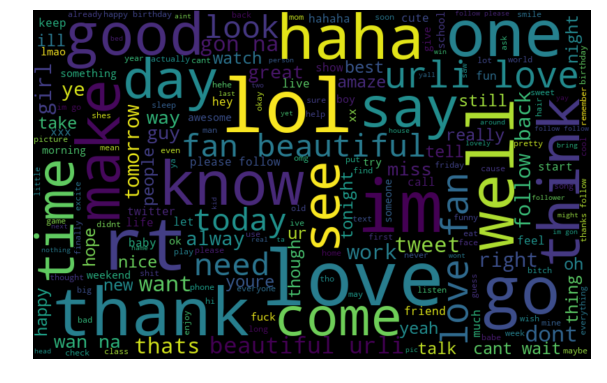

In [80]:
cloud_words(train_pos_tok)

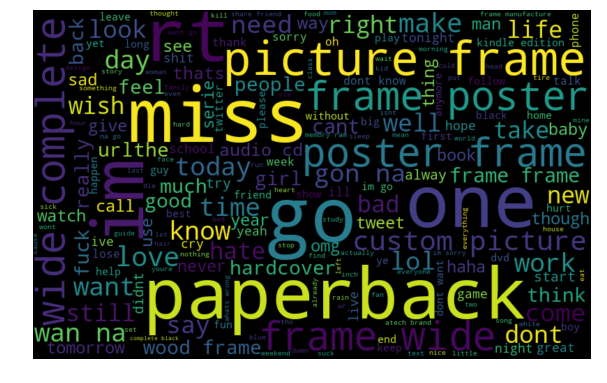

In [82]:
cloud_words(train_neg_tok)